# Introduction

In this tutorial, we will explain the basics of using Data Detective to perform a Data Investigation. In this tutorial, we will go through the steps of setting up and running a basic Data Detective Investigation, including: 
1. Configuring a dataset that works with Data Detective. 
2. Setting up a schema that defines the Data Detective investigation. 
3. Executing a data detective investigation. 
4. Summarizing results using the built-in Rank Aggregator


We will also include supplemental tutorials for some of Data Detective's more advanced features, including: 
- Extending the Data Detective investigation with custom validations
- Extending the transform library to map custom datatypes to supported datatypes


Let's get started!


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import PIL
import time
import torch
import torchvision.transforms as transforms


from torchvision.datasets import MNIST
from typing import Dict, Union
from tqdm import tqdm

from constants import FloatTensor
from src.aggregation.rankings import RankingAggregator, RankingAggregationMethod
from src.data_detective_engine import DataDetectiveEngine
from src.datasets.tutorial_dataset import TutorialDataset
from src.datasets.my_fashion_mnist import MyFashionMNIST
from src.enums.enums import DataType
from src.transforms.embedding_transformer import Transform
from src.transforms.transform_library import TRANSFORM_LIBRARY


/Users/mcconnl3/Code/data-detective/dd_env/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
dataset = MyFashionMNIST(
    root='./data/FashionMNIST',
    download=True,
    transform=transforms.Compose([
        transforms.ToTensor() 
    ])
)
dataset.__len__()

10000

In [3]:
inference_size: int = 20
everything_but_inference_size: int = dataset.__len__() - inference_size
inference_dataset, everything_but_inference_dataset = torch.utils.data.random_split(dataset, [inference_size, dataset.__len__() - inference_size])
    
train_size: int = int(0.6 * len(everything_but_inference_dataset))
val_size: int = int(0.2 * len(everything_but_inference_dataset))
test_size: int = len(everything_but_inference_dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(everything_but_inference_dataset, [train_size, val_size, test_size])

data_object: Dict[str, torch.utils.data.Dataset] = {
    "training_set": train_dataset,
    "validation_set": val_dataset,
    "test_set": test_dataset,
    "entire_set": dataset,
    "everything_but_inference_set": everything_but_inference_dataset,
    "inference_set": inference_dataset
}

print(f"size of inference_dataset: {inference_dataset.__len__()}")
print(f"size of everything_but_inference_dataset: {everything_but_inference_dataset.__len__()}")
print(f"size of train_dataset: {train_dataset.__len__()}")
print(f"size of entire dataset: {dataset.__len__()}")
print(f"size of val_dataset: {val_dataset.__len__()}")
print(f"size of test_dataset: {test_dataset.__len__()}")

size of inference_dataset: 20
size of everything_but_inference_dataset: 9980
size of train_dataset: 5988
size of entire dataset: 10000
size of val_dataset: 1996
size of test_dataset: 1996


# Setting up a Validation Schema

In [4]:
validation_schema : Dict = {
    "validators": {
        "unsupervised_anomaly_data_validator": {},
    }
}

In [5]:
transform_schema : Dict = {
    "transforms": {
        "image": [{
            "name": "resnet50",
            "in_place": "False",
            "options": {},
        }],
    }
}
    
full_validation_schema: Dict = {
    **validation_schema, 
    **transform_schema
}

# Running the Data Detective Engine

In [7]:
data_detective_engine = DataDetectiveEngine()

start_time = time.time()
results = data_detective_engine.validate_from_schema(full_validation_schema, data_object)

# results = data_detective_engine.validate_from_schema(full_validation_schema, data_object)
print("--- %s seconds ---" % (time.time() - start_time))

running validator class unsupervised_anomaly_data_validator...
thread 13080924160 entered to handle validator method cblof_anomaly_validator_methodthread 13097713664 entered to handle validator method pca_anomaly_validator_method
thread 13097713664:    running pca_anomaly_validator_method...

thread 13080924160:    running cblof_anomaly_validator_method...
thread 13114503168 entered to handle validator method iforest_anomaly_validator_method
thread 13114503168:    running iforest_anomaly_validator_method...


/Users/mcconnl3/Code/data-detective/dd_env/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


thread 13114503168: finished
thread 13080924160: finished
thread 13097713664: finished
--- 195.5421130657196 seconds ---


# Setting Up Occlusion Functions

In [8]:
resnet = TRANSFORM_LIBRARY['resnet50'].initialize_transform({})

In [9]:
import torch.nn as nn
import copy

from torch.nn.functional import pad

from constants import FloatTensor

class OcclusionTransform(nn.Module):
    def __init__(self, width=5):
        super().__init__()
        self.width = width
        
        if width % 2 != 1: 
            raise Exception("Width must be an odd number")
        
    def forward(self, tensor, loc): 
        tensor = copy.deepcopy(tensor)
        width = self.width
        
        diff = (width - 1) / 2
        first_dim, second_dim = loc[0], loc[1]
        
        min_val_first = np.round(max(0, first_dim - diff)).astype(int)
        min_val_second = np.round(max(0, second_dim - diff)).astype(int)
        
        max_val_first = np.round(min(tensor.shape[1], first_dim + diff + 1)).astype(int)
        max_val_second = np.round(min(tensor.shape[1], second_dim + diff + 1)).astype(int)
        
        tensor[:, min_val_first:max_val_first, min_val_second:max_val_second].fill_(0)
        
        return tensor

In [84]:
def plot_occ_results(img, localized_anomaly_score, width, color_bounds):
    if color_bounds != "auto":
        vmin, vmax = color_bounds
    else: 
        vmin, vmax = None, None
    
    im = box_blur(localized_anomaly_score, width)
    im = im.reshape(im.shape[-2:])
    
    plt.imshow(img.reshape(img.shape[-2:]), cmap='Greys_r')
    plt.colorbar()
    plt.suptitle("Original Image")
    plt.show()

    plt.imshow(im, vmin=vmin, vmax=vmax, cmap='plasma')
    plt.colorbar()
    plt.suptitle(f"Blurred anomaly occlusion heatmap (width {width})")
    plt.show()

    plt.imshow(localized_anomaly_score, vmin=vmin, vmax=vmax, cmap='plasma')
    plt.colorbar()
    plt.suptitle(f"Unblurred anomaly occlusion heatmap (width {width})")
    plt.show()

    
def box_blur(tensor, width):
    def get_sum(sum_table,
            min_val_first, 
            min_val_second, 
            max_val_first, 
            max_val_second
    ):
        x = 0
        x += sum_table[max_val_first][max_val_second] 

        if min_val_second != 0: 
            x -= sum_table[max_val_first][min_val_second - 1]

        if min_val_first != 0:
            x -= sum_table[min_val_first - 1][max_val_second] 

        if not (min_val_first == 0 or min_val_second == 0):
            x += sum_table[min_val_first - 1][min_val_second - 1]

        return x

    def compute_overlaps(tensor, patch_size=(3, 3), patch_stride=(1, 1)):
        width = (patch_size[0] - 1) // 2
        tensor = FloatTensor(tensor)
        tensor = pad(tensor, (width, width, width, width), "constant", 0)
        while len(tensor.shape) < 4:
            tensor = tensor.reshape((-1, *tensor.shape))

        n, c, h, w = tensor.size()
        px, py = patch_size
        sx, sy = patch_stride
        nx = ((w-px)//sx)+1
        ny = ((h-py)//sy)+1

        overlaps = torch.zeros(tensor.size()).type_as(tensor.data)
        for i in range(ny):
            for j in range(nx):
                overlaps[:, :, i*sy:i*sy+py, j*sx:j*sx+px] += 1
        overlaps = torch.autograd.Variable(overlaps)
        return overlaps[:,:,width:-width,width:-width]

    sum_table = tensor.cumsum(axis=0).cumsum(axis=1)

    res = np.zeros(tensor.shape)
    first_dim_size = tensor.shape[-2]
    second_dim_size = tensor.shape[-1]
    diff = np.round((width - 1) // 2).astype(int)


    for first_dim in range(first_dim_size): 
        for second_dim in range(second_dim_size): 

            min_val_first = np.round(max(0, first_dim - diff)).astype(int)
            min_val_second = np.round(max(0, second_dim - diff)).astype(int)

            max_val_first = np.round(min(tensor.shape[1] - 1, first_dim + diff)).astype(int)
            max_val_second = np.round(min(tensor.shape[1] - 1, second_dim + diff)).astype(int)

            res[first_dim][second_dim] = get_sum(sum_table,
                min_val_first, 
                min_val_second, 
                max_val_first, 
                max_val_second
            )

    overlap = compute_overlaps(tensor, patch_size=(width, width))
        
    return res / overlap
    
    
def occlusion_interpretability(img, model, occ, color_bounds="auto"):    
    occluded_image_dict = {}
    for first_dim in range(img.shape[1]):
        for second_dim in range(img.shape[2]):
            occluded = occ(img, (first_dim, second_dim))
            occluded_image_dict[tuple((first_dim, second_dim))] = occluded

            
    embeddings = np.concatenate([resnet(img) for img in tqdm(occluded_image_dict.values())], axis=0)
#     embeddings = np.concatenate(Parallel(n_jobs=6)(delayed(resnet)(img) for img in tqdm(occluded_image_dict.values())), axis=0)
    localized_anomaly_scores = model.decision_function(embeddings)
    reshaped_localized_anomaly_score = torch.FloatTensor(list(localized_anomaly_scores)).reshape(img.shape[-2:])

    plot_occ_results(img, reshaped_localized_anomaly_score, occ.width, color_bounds)
    return reshaped_localized_anomaly_score

METHOD = 'cblof_anomaly_validator_method'

# Performance on Average (repeat: random) Datapoint



100%|███████████████████████████████████████| 784/784 [00:00<00:00, 9779.23it/s]


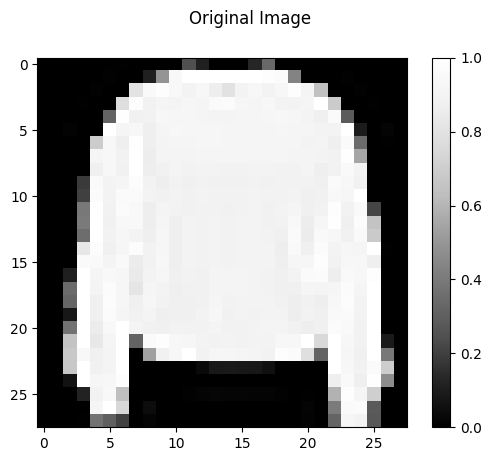

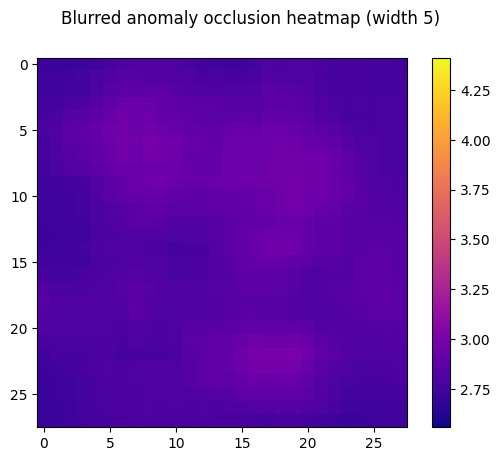

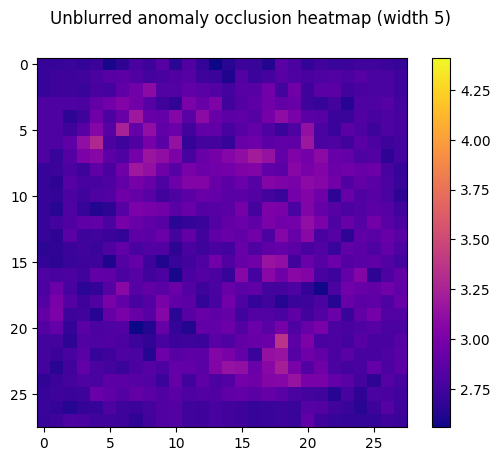

In [86]:
sample = dataset[7]
img = sample['image']
occ = OcclusionTransform(width=5)
occed = occ(img, (15, 15))

model_results, model = results['unsupervised_anomaly_data_validator'][METHOD]['resnet50_backbone_image_results']
res_min, res_max = model_results.min(), model_results.max()
interp_results = occlusion_interpretability(img, model, occ, (res_min, res_max))

# occluded_image_dict = {}
# for first_dim in range(img.shape[1]):
#     for second_dim in range(img.shape[2]):
#         occluded = occ(img, (first_dim, second_dim))
#         occluded_image_dict[tuple((first_dim, second_dim))] = occluded

# embeddings = np.concatenate([resnet(img) for img in tqdm(occluded_image_dict.values())], axis=0)
  

array([3.52649164, 3.47043109, 3.30923557, ..., 3.55399251, 3.21994686,
       3.06105375])

# Most Anomalous Image Test

In [64]:
argmax = model_results.argmax()

In [65]:
model_results[argmax]

0.056134209973753846

4


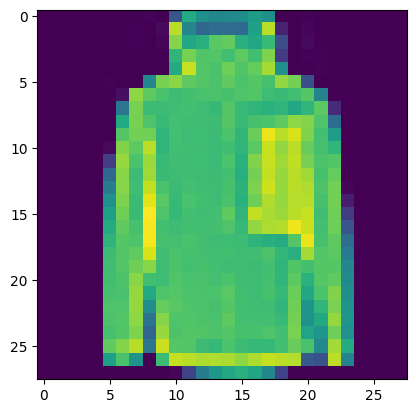

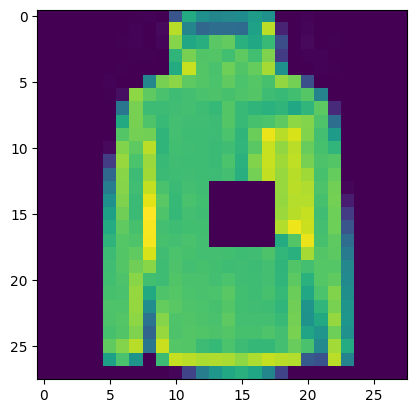

In [66]:
print(dataset[argmax]['label'])
image = dataset[argmax]['image']
# image = sample['image']
occ = OcclusionTransform(width=5)
occed = occ(image, (15, 15))
_, model = results['unsupervised_anomaly_data_validator'][METHOD]['resnet50_backbone_image_results']


plt.figure()
plt.imshow(image.squeeze())
plt.show()
plt.imshow(occed.squeeze())
plt.show()

# middle_of_shoe = image[:, 10:20, 15:25]
# plt.imshow(middle_of_shoe.squeeze())
# plt.show()

100%|███████████████████████████████████████| 784/784 [00:00<00:00, 7402.52it/s]


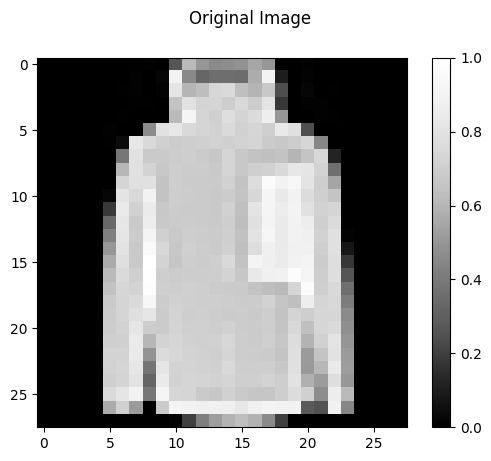

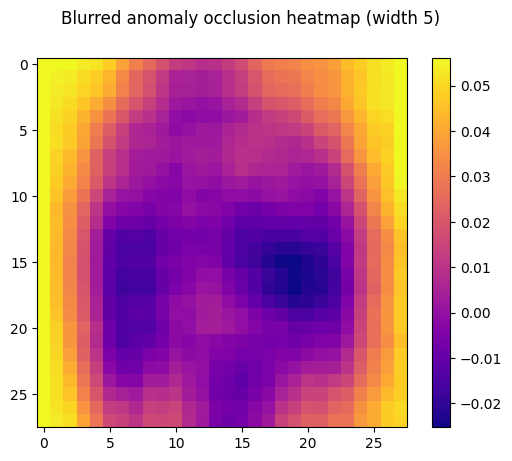

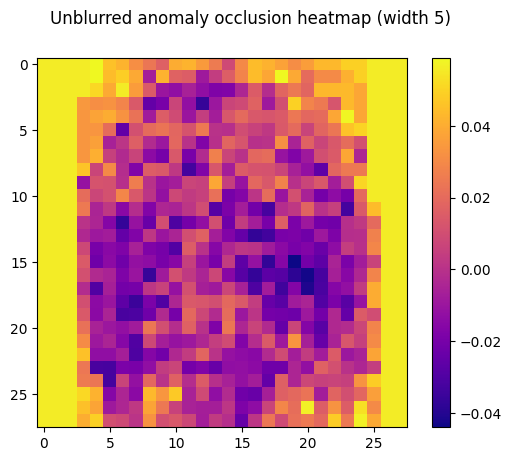

100%|███████████████████████████████████████| 784/784 [00:00<00:00, 9937.52it/s]


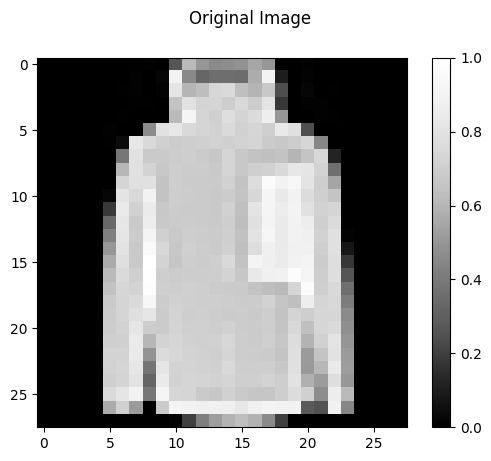

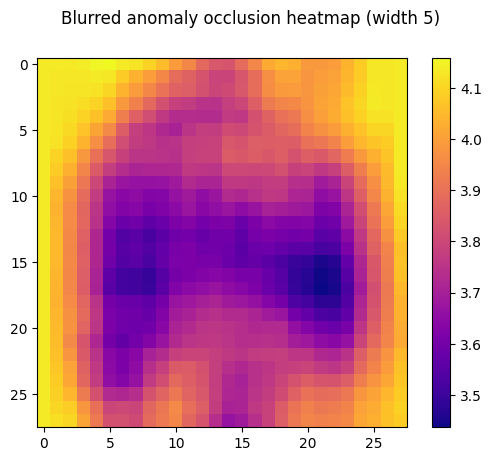

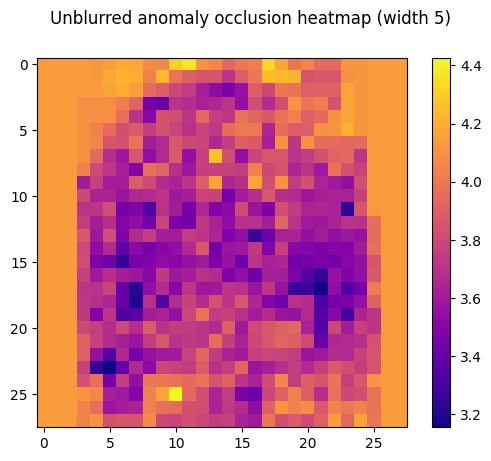

100%|██████████████████████████████████████| 784/784 [00:00<00:00, 10234.69it/s]


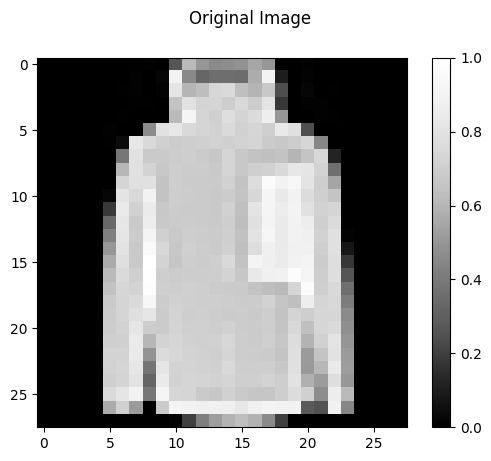

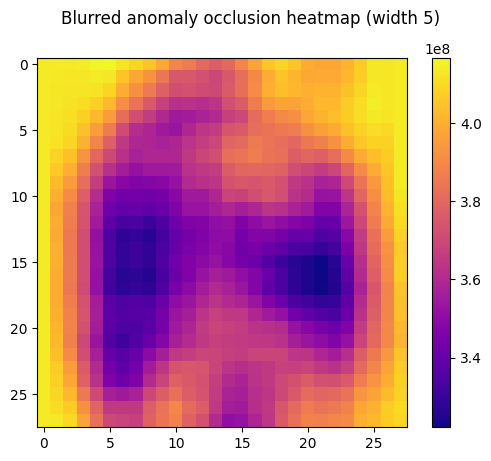

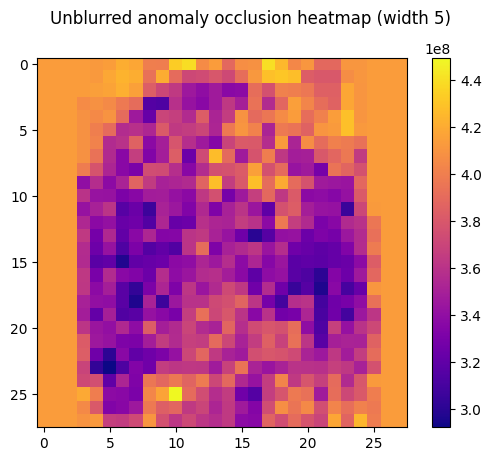

In [78]:
sample = dataset[argmax]
img = sample['image']
occ = OcclusionTransform(width=5)
occed = occ(img, (15, 15)) 

for method in ['iforest', 'cblof', 'pca']:
    method_name = f'{method}_anomaly_validator_method'
    model_results, model = results['unsupervised_anomaly_data_validator'][method_name]['resnet50_backbone_image_results']
    res_min, res_max = model_results.min(), model_results.max()
    interp_results = occlusion_interpretability(img, model, occ)

# Added Localized Anomaly Benchmarks

In [53]:
sample = dataset[7]
img = sample['image']

img_altered = copy.deepcopy(img)
checkerboard = np.indices((7, 7)).sum(axis=0) % 2
img_altered[:,:7,:7] = FloatTensor(checkerboard)

occ = OcclusionTransform(width=11)
# occed = occ(img_altered, (0, 0))

In [56]:
r1 = resnet(img)
r2 = resnet(img_altered)

print(f"after anomaly, resnet embeddings have a summed abs difference of {np.sum(np.abs(r1 - r2))}")
print(f"after anomaly, model results have a difference of {model.decision_function(r2) - model.decision_function(r1)}")

after anomaly, resnet embeddings have a summed abs difference of 124.22842407226562
after anomaly, model results have a difference of [0.02820845]


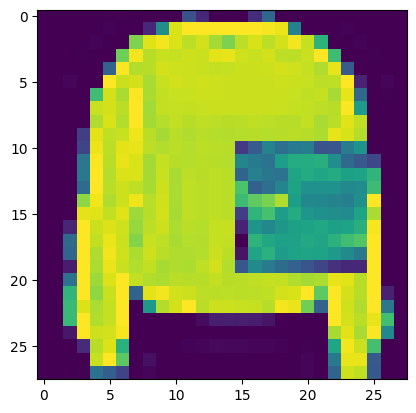

In [40]:
plt.imshow(img_altered.squeeze())

In [41]:
model.decision_function(resnet(img))

array([2.69955254])

100%|█████████████████████████████████████████| 784/784 [00:37<00:00, 21.12it/s]


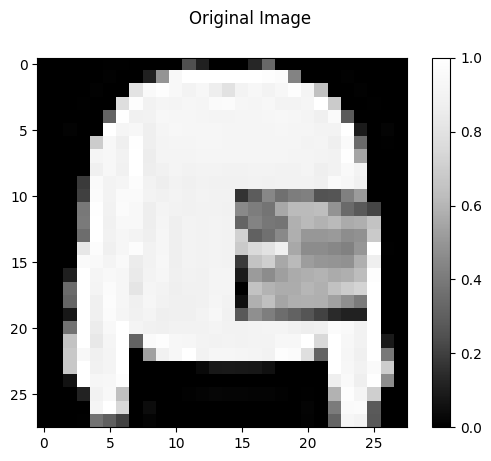

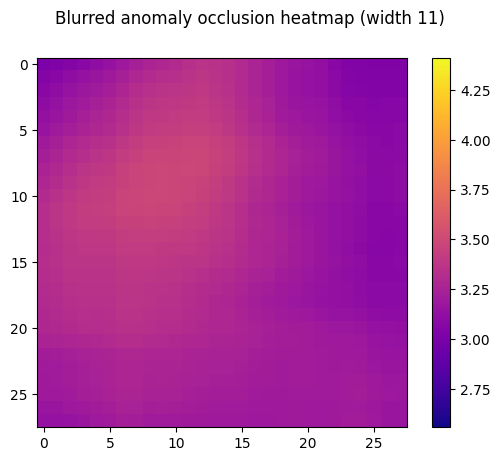

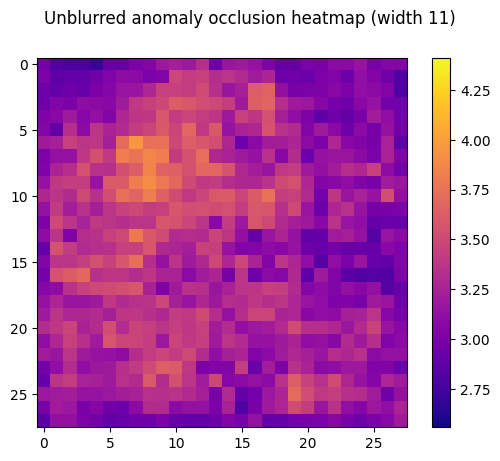

In [42]:
model_results, model = results['unsupervised_anomaly_data_validator'][METHOD]['resnet50_backbone_image_results']
res_min, res_max = model_results.min(), model_results.max()
interp_results = occlusion_interpretability(img_altered, model, occ, (res_min, res_max))

100%|█████████████████████████████████████████| 784/784 [02:57<00:00,  4.42it/s]


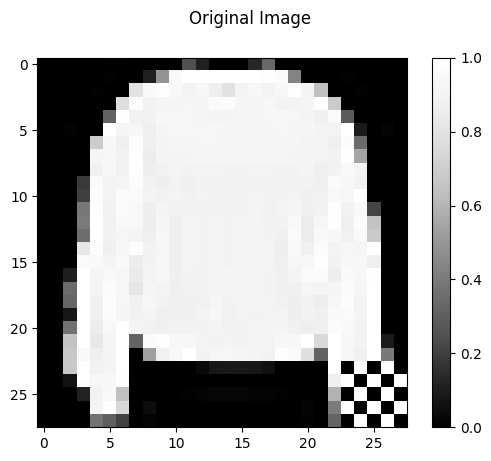

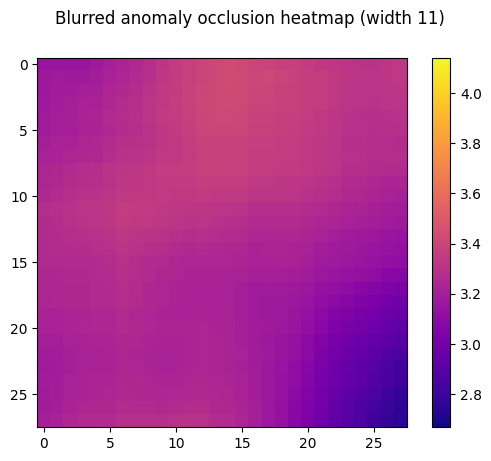

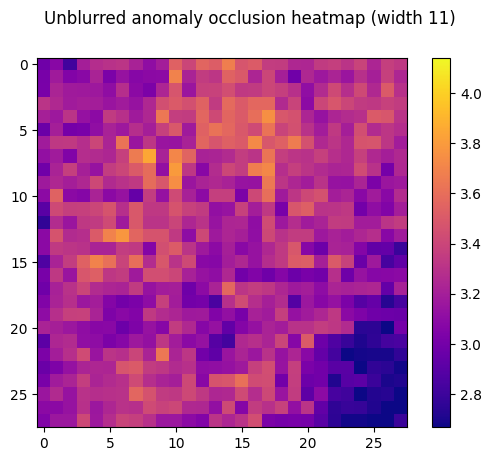

In [60]:
sample = dataset[7]
img = sample['image']

img_altered = copy.deepcopy(img)
checkerboard = np.indices((5, 5)).sum(axis=0) % 2
img[:,-5:,-5:] = FloatTensor(checkerboard)

occ = OcclusionTransform(width=11)
model_results, model = results['unsupervised_anomaly_data_validator'][METHOD]['resnet50_backbone_image_results']
res_min, res_max = model_results.min(), model_results.max()
interp_results = occlusion_interpretability(img, model, occ, (res_min, res_max))

100%|█████████████████████████████████████████| 784/784 [03:07<00:00,  4.19it/s]


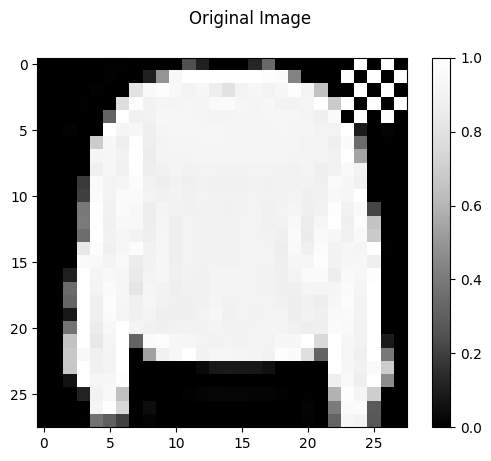

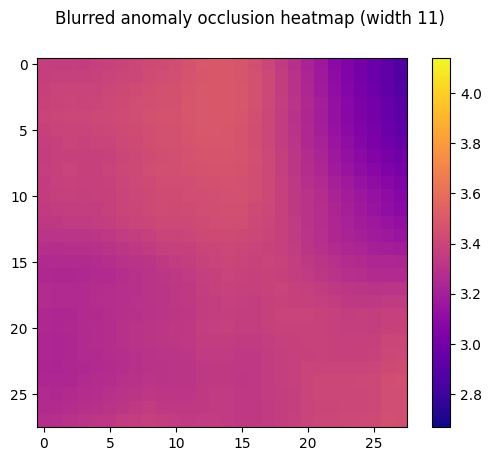

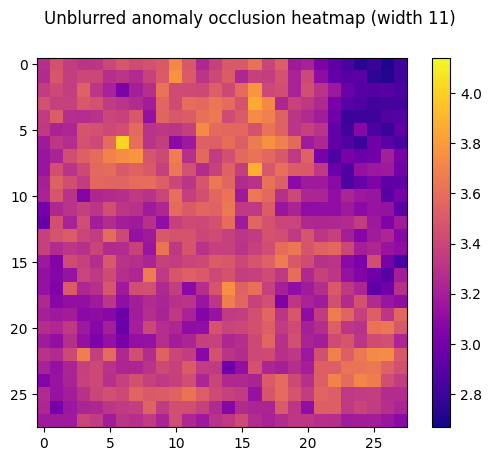

In [61]:
sample = dataset[7]
img = sample['image']

img_altered = copy.deepcopy(img)
checkerboard = np.indices((5, 5)).sum(axis=0) % 2
img[:,:5,-5:] = FloatTensor(checkerboard)

occ = OcclusionTransform(width=11)
model_results, model = results['unsupervised_anomaly_data_validator'][METHOD]['resnet50_backbone_image_results']
res_min, res_max = model_results.min(), model_results.max()
interp_results = occlusion_interpretability(img, model, occ, (res_min, res_max))

100%|█████████████████████████████████████████| 784/784 [03:05<00:00,  4.22it/s]


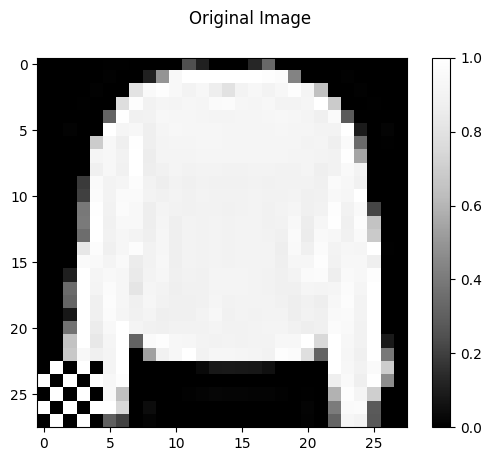

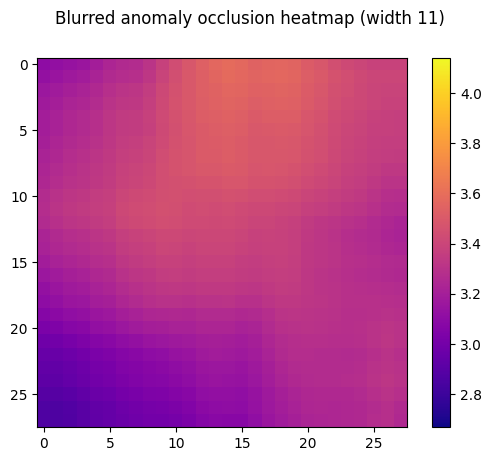

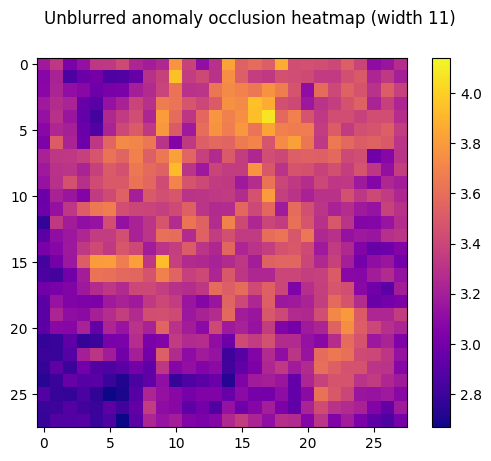

In [62]:
sample = dataset[7]
img = sample['image']

img_altered = copy.deepcopy(img)
checkerboard = np.indices((5, 5)).sum(axis=0) % 2
img[:,-5:,:5] = FloatTensor(checkerboard)

occ = OcclusionTransform(width=11)
model_results, model = results['unsupervised_anomaly_data_validator'][METHOD]['resnet50_backbone_image_results']
res_min, res_max = model_results.min(), model_results.max()
interp_results = occlusion_interpretability(img, model, occ, (res_min, res_max))

100%|█████████████████████████████████████████| 784/784 [03:04<00:00,  4.24it/s]


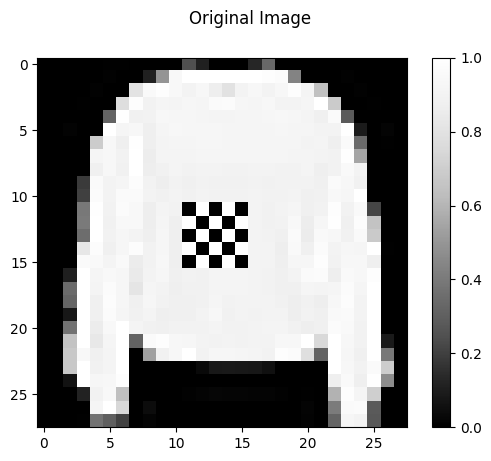

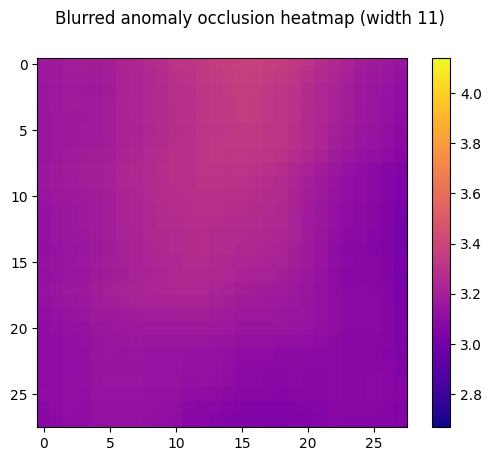

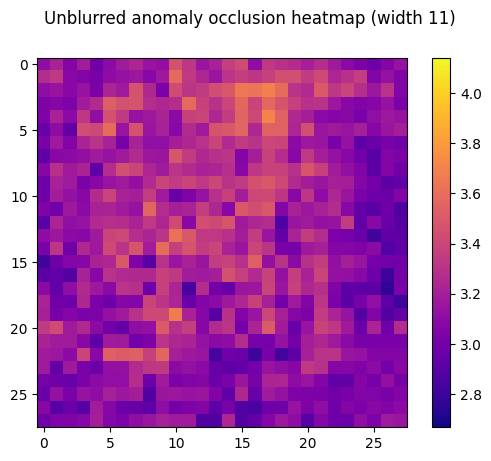

In [63]:
sample = dataset[7]
img = sample['image']

img_altered = copy.deepcopy(img)
checkerboard = np.indices((5, 5)).sum(axis=0) % 2
img[:,11:16,11:16] = FloatTensor(checkerboard)

occ = OcclusionTransform(width=11)
model_results, model = results['unsupervised_anomaly_data_validator'][METHOD]['resnet50_backbone_image_results']
res_min, res_max = model_results.min(), model_results.max()
interp_results = occlusion_interpretability(img, model, occ, (res_min, res_max))

# Nonlocalized Anomaly Benchmarks 

In [46]:
noise = torch.randn(img.shape)* 0.2

100%|█████████████████████████████████████████| 784/784 [02:04<00:00,  6.31it/s]


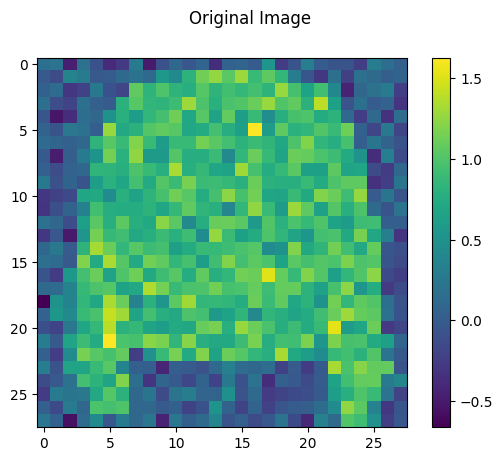

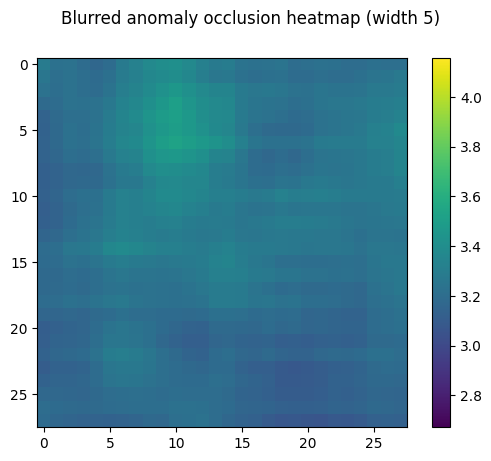

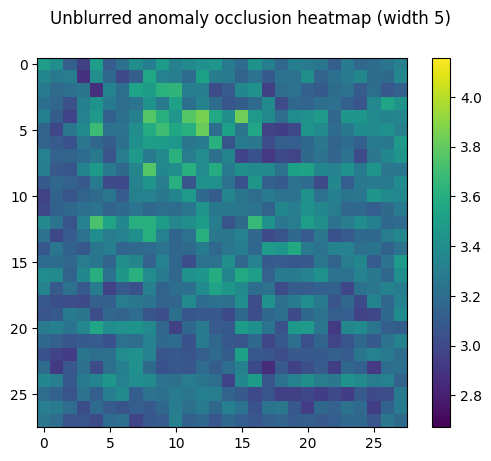

In [53]:
sample = dataset[7]
img = sample['image']
img = copy.copy(img)
img += noise
# plt.imshow(img.reshape(img.shape[-2:]))

occ = OcclusionTransform(width=5)
occed = occ(img, (15, 15))

model_results, model = results['unsupervised_anomaly_data_validator'][METHOD]['resnet50_backbone_image_results']
res_min, res_max = model_results.min(), model_results.max()
occlusion_interpretability(img, model, occ, (res_min, res_max))

# Occlusion Transparency Tests

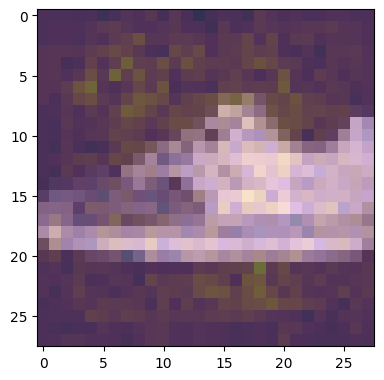

In [93]:
interp_results
original_image = dataset[529]['image']
original_image.reshape((28, 28))
interp_results.shape

img = original_image
heatmap = interp_results

colormap = 'plasma'
fig = plt.figure(figsize=(20,20))

ax2 = plt.subplot(1, 4, 3, aspect='equal')
ax2.imshow(np.squeeze(img), alpha = .75, cmap='Greys_r')
hm = ax2.imshow(heatmap, alpha = 0.25, cmap='plasma')